<a href="https://colab.research.google.com/github/flaviopradoaquino/trabalhospark/blob/main/trabalhospark_estatistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Instalação de Pacotes**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=9e8cdc2a5603f4e8912e77720a6fb769fa42040fe5a0801b3d7e2e4a2f5d9c62
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## **Importação dos Pacotes**

In [38]:
import string
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max, when, isnan
from pyspark.sql.functions import upper, col
from pyspark.sql import functions as sf
from scipy.stats import pearsonr
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels

## **Inicia a sessão do Spark**

In [3]:
spark = SparkSession.builder.appName("AtividadeFinal").master('local[*]').getOrCreate()

## **Carrega os arquivos CSVs e adicona o encode para permitir acentuação**

In [4]:
idh = "/content/sample_data/idh_2010_tratado.csv"
enem = "/content/sample_data/enem_2022_tratado.csv"

In [6]:
df_i = spark.read.options(delimiter=";", header=True).option("encoding", "ISO-8859-1").csv(idh)
df_e = spark.read.options(delimiter=";", header=True).option("encoding", "ISO-8859-1").csv(enem)

## **Montagem do Dataframe**

In [8]:
### Exclusão de campos que não serão usados
df_i = df_i.drop(*('NM_FEDERACAO','IDHM'))

In [10]:
### Exclusão dos registros de municípios duplicados
df_i = df_i.dropDuplicates(['NM_MUNICIPIO'])

In [12]:
### Colocar emletras maiúsculas o campo 'Municípios' do Dataframe Enem
df_e = df_e.withColumn("NO_MUNICIPIO", upper(df_e.NO_MUNICIPIO_PROVA))

### Atriubuir um identificador único para cada registro do Dataframe Enem
df_e = df_e.select("*").withColumn("id", sf.monotonically_increasing_id())

### Exclusão dos campos que não serão usados
df_e = df_e.drop(*('NU_INSCRICAO', 'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'IN_TREINEIRO'))

In [14]:
### Join dos Datafrmaes IDH e Enem pelo Município
df = df_e.join(df_i, df_e.NO_MUNICIPIO == df_i.NM_MUNICIPIO, "left" )
df = df.drop('NM_MUNICIPIO')

In [16]:
### Exclusão dos registros nulos de notas de Matemática e Redação
df = df.na.drop(how="any")

In [17]:
df.show()

+-------+-----------+---------+-----------+----------+---------------+--------------------+---+---+
|TP_SEXO|TP_COR_RACA|TP_ESCOLA|SG_UF_PROVA|NU_NOTA_MT|NU_NOTA_REDACAO|        NO_MUNICIPIO| id|IDH|
+-------+-----------+---------+-----------+----------+---------------+--------------------+---+---+
|      F|          2|        1|         BA|       565|            760|PRESIDENTE TANCRE...|  2|559|
|      M|          3|        1|         ES|       416|            320|           CARIACICA|  3|718|
|      F|          2|        1|         RJ|       405|            440|         SÃO GONÇALO|  7|739|
|      F|          3|        1|         PE|       435|            360|           ARCOVERDE|  9|667|
|      F|          1|        3|         SE|       457|            940|NOSSA SENHORA DA ...| 11|587|
|      F|          3|        1|         SP|       536|            640|       CARAGUATATUBA| 17|759|
|      F|          3|        1|         PE|       463|              0|             CARPINA| 20|680|


In [19]:
### Correção do tipo de dados para campos quantitativos
df = df.withColumn("NU_NOTA_MT",df.NU_NOTA_MT.cast('int'))
df = df.withColumn("NU_NOTA_REDACAO",df.NU_NOTA_REDACAO.cast('int'))
df = df.withColumn("IDH",df.IDH.cast('int'))

In [20]:
df.printSchema()

root
 |-- TP_SEXO: string (nullable = true)
 |-- TP_COR_RACA: string (nullable = true)
 |-- TP_ESCOLA: string (nullable = true)
 |-- SG_UF_PROVA: string (nullable = true)
 |-- NU_NOTA_MT: integer (nullable = true)
 |-- NU_NOTA_REDACAO: integer (nullable = true)
 |-- NO_MUNICIPIO: string (nullable = true)
 |-- id: long (nullable = false)
 |-- IDH: integer (nullable = true)



## **Análise Estatística**

In [21]:
### Convertendo Dataframe Pyspark para Pandas
df_p = df.toPandas()

In [22]:
df_p

,TP_SEXO,TP_COR_RACA,TP_ESCOLA,SG_UF_PROVA,NU_NOTA_MT,NU_NOTA_REDACAO,NO_MUNICIPIO,id,IDH
0,F,2,1,BA,565,760,PRESIDENTE TANCREDO NEVES,2,559
1,M,3,1,ES,416,320,CARIACICA,3,718
2,F,2,1,RJ,405,440,SÃO GONÇALO,7,739
3,F,3,1,PE,435,360,ARCOVERDE,9,667
4,F,1,3,SE,457,940,NOSSA SENHORA DA GLÓRIA,11,587
...,...,...,...,...,...,...,...,...,...
685947,F,3,2,PR,499,780,COLORADO,8590413608,730
685948,M,1,1,RJ,517,800,RIO DE JANEIRO,8590413609,799
685949,F,3,1,PA,469,760,BARCARENA,8590413610,662
685950,M,1,2,SC,579,560,ITAPEMA,8590413611,796


In [28]:
col_mat = df_p['NU_NOTA_MT']
col_red = df_p['NU_NOTA_REDACAO']
col_idh = df_p['IDH']

**Coeficiente de correlação de Pearson**

Na correlação dePearson, a métrica da linearidade entre variáveis é exposta em um número que vai de -1 a +1. Quanto mais próximo dos extremos (-1 ou 1), maior é a força da correlação. Valores próximos de zero querem dizer a correlação é fraca.

In [29]:
### Correlação notas de Matemática com as notas de Redação
corr, _ = pearsonr(col_mat, col_red)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.482


In [30]:
### Correlação notas de Matemática com o valor do IDH do Município de residência do aluno
corr, _ = pearsonr(col_mat, col_idh)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.197


In [31]:
### Correlação notas de Redação com o valor do IDH do Município de residência do aluno
corr, _ = pearsonr(col_red, col_idh)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.101


**Teste de aderência à Normalidade**

A distribuição normal também pode ser chamada de gaussiana e sua forma assemelha-se a de um sino.

<ipython-input-33-da065f2cd0c7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['NU_NOTA_MT'], color="dodgerblue", label="Compact",)


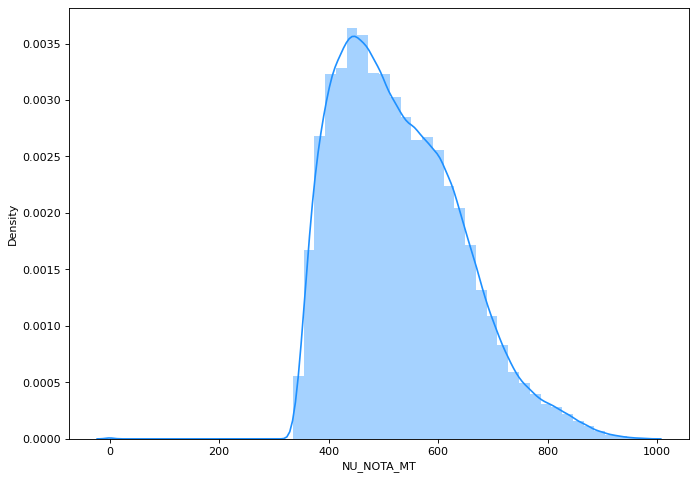

In [33]:
### Gráfico de distribuição dos dados das notas de Matemática
## Visualmente os dados se aproximam da normalidade
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df_p['NU_NOTA_MT'], color="dodgerblue", label="Compact",)
plt.show()

<ipython-input-35-633c4c3b940d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['NU_NOTA_REDACAO'], color="dodgerblue", label="Compact",)


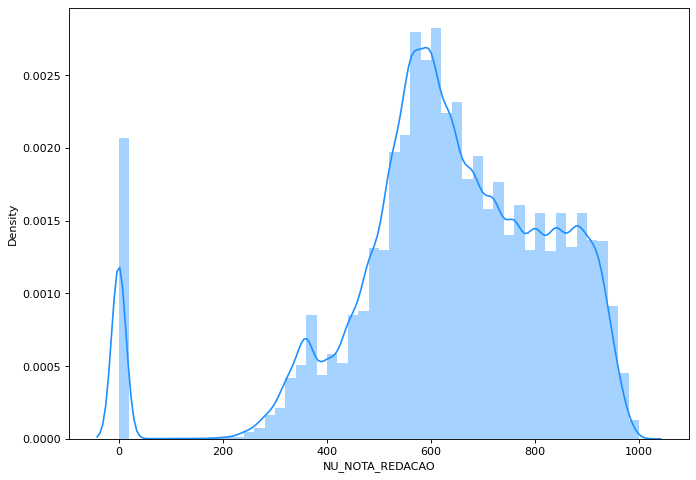

In [35]:
### Gráfico de distribuição dos dados das notas de Redação
## Visualmente os dados não se aproximam da normalidade
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df_p['NU_NOTA_REDACAO'], color="dodgerblue", label="Compact",)
plt.show()

<ipython-input-36-dea019a854be>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_p['IDH'], color="dodgerblue", label="Compact",)


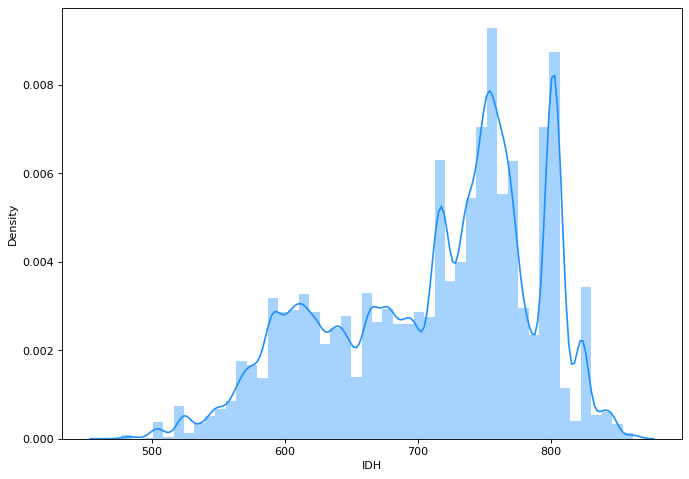

In [36]:
### Gráfico de distribuição dos dados de IDH dos Municípios
## Visualmente os dados não se aproximam da normalidade
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df_p['IDH'], color="dodgerblue", label="Compact",)
plt.show()

**Teste de Shapiro-Wilk**

O Teste de Shapiro-Wilk tem como objetivo avaliar se uma distribuição é semelhante a uma distribuição normal.

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [42]:
### Notas de Matemática
e, p = stats.shapiro(df_p['NU_NOTA_MT'])
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9647639393806458
p-valor: 0.0


In [43]:
### Notas de Redação
e, p = stats.shapiro(df_p['NU_NOTA_REDACAO'])
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9291774034500122
p-valor: 0.0


In [44]:
### IDH dos Municípios
e, p = stats.shapiro(df_p['IDH'])
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9560688138008118
p-valor: 0.0
